# Sparkify Project Workspace
This workspace uses a [subset]('data/mini_sparkify_event_data.json') (128MB) of the full dataset available (12GB). Within this workspace we will create and evaluate different versions of a model to predict user churns. The best resulting model will then be used to evaluate on a larger dataset within IBM cloud.

In [1]:
# import libraries
from pyspark.sql import SparkSession, Window, Column
from pyspark.sql.functions import  asc, desc, udf, col, lit, first, max
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import expr as expr
from pyspark.sql.functions import year, month, dayofmonth, concat_ws, count
from pyspark.sql.functions import max, when
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import  VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier,\
    GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline



import datetime
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify Project") \
    .getOrCreate()


your 131072x1 screen size is bogus. expect trouble
23/11/07 14:03:53 WARN Utils: Your hostname, Pinocchio resolves to a loopback address: 127.0.1.1; using 172.18.43.111 instead (on interface eth0)
23/11/07 14:03:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/07 14:03:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load and Clean Dataset
Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

### Load Dataset

In [3]:

sparkify_data = 'data/mini_sparkify_event_data.json'

In [4]:
df = spark.read.json(sparkify_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

### Analyse the Dataset
Check how many rows and columns we have, what the structure of the data is and how the content looks in terms of values and completeness.

In [5]:
type(df)

pyspark.sql.dataframe.DataFrame

In [6]:
# num_rows = pd_df.shape[0] #Provide the number of rows in the dataset
# num_cols = pd_df.shape[1] #Provide the number of columns in the dataset
num_rows = df.count()
num_cols = len(df.columns)
print(f'dataset contains {num_rows} rows with {num_cols} columns')

dataset contains 286500 rows with 18 columns


In [7]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
df.take(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [9]:
df.describe().show()

23/11/07 14:04:07 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

How complete is the data?

In [10]:
column_percentages = []

for column in df.columns:
    count = df.filter(df[column].isNotNull()).count()
    percentage = (count / df.count()) * 100
    column_percentages.append((column, percentage))

# Create a summary DataFrame
from pyspark.sql import Row
summary_rdd = spark.sparkContext.parallelize([Row(Column_Name=item[0], Percentage_of_Existing_Values=item[1]) for item in column_percentages])
summary_df = spark.createDataFrame(summary_rdd)

# Sort the summary DataFrame by the percentage in descending order
summary_df = summary_df.orderBy(summary_df["Percentage_of_Existing_Values"].desc())

# Display the summary
summary_df.show()

+-------------+-----------------------------+
|  Column_Name|Percentage_of_Existing_Values|
+-------------+-----------------------------+
|         auth|                        100.0|
|itemInSession|                        100.0|
|        level|                        100.0|
|       method|                        100.0|
|         page|                        100.0|
|    sessionId|                        100.0|
|       status|                        100.0|
|           ts|                        100.0|
|       userId|                        100.0|
|    firstName|             97.0869109947644|
|       gender|             97.0869109947644|
|     lastName|             97.0869109947644|
|     location|             97.0869109947644|
| registration|             97.0869109947644|
|    userAgent|             97.0869109947644|
|       artist|            79.61884816753927|
|       length|            79.61884816753927|
|         song|            79.61884816753927|
+-------------+-------------------

From the information of the tables of the tables above we may draw some conclusions. Basically the data is structured in the parts related to the 
* user (name, gender , location, ...)
* the user session (page, method, status, ...)
* played songs (artist, length, ...)


|Column|Percentage Filled|Comment|
|------|-------|-------|
|         auth|                        100.0|authorization status of user for this activity|
|itemInSession|                        100.0|not sure what this is|
|        level|                        100.0|user's account level (from free to paid)|
|       method|                        100.0|how the website was accessed from browser|
|         page|                        100.0|page user visited|
|    sessionId|                        100.0|id of the session with which user is currently identified (browser session)|
|       status|                        100.0|status of the current web request from browser|
|           ts|                        100.0|a timestamp|
|       userId|                        100.0|user's unique id. We see a strange min value here and will care about it within the data cleaning.|
|    firstName|             97.0869109947644| user's firstname|
|       gender|             97.0869109947644|user's gender|
|     lastName|             97.0869109947644|user's lastName|
|     location|             97.0869109947644| user's location|
| registration|             97.0869109947644|not sure what this is. Might be the timestamp of when user registered.|
|    userAgent|             97.0869109947644| user's browser|
|       artist|            79.61884816753927|artist of the song played|
|       length|            79.61884816753927|length of played song|
|         song|            79.61884816753927|title of the song played|




Are there userIds for which we do not have information about name, gender aso?

In [11]:
from pyspark.sql.functions import col, count, when

# Initialize a Spark session
spark = SparkSession.builder.appName("FindUsersWithMissingInfo").getOrCreate()

# Assuming your DataFrame is named df
result = df.groupBy("userId") \
    .agg(
        count(when(col("gender").isNotNull(), 1)).alias("gender_count"),
        count(when(col("lastName").isNotNull(), 1)).alias("lastName_count"),
        count(when(col("location").isNotNull(), 1)).alias("location_count")
    ) \
    .filter((col("gender_count") == 0 ) | (col("lastName_count") == 0) | (col("location_count") == 0)) \
    .select("userId")

result.show()

23/11/07 14:04:21 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+------+
|userId|
+------+
|      |
+------+



So, looks like user information is complete for all userIds!

We will at least need userId, sessionId and also page (representing our events) for all further evaluations, so let us first check and clean on them.
#### Clean on userId, page and sessionId
drop all rows where we have no sessionId or page

In [12]:
df_clean = df.dropna(how = "any", subset = [ "sessionId", "page"])

Now let us have a deeper llook at the actual values, starting with userId.

In [13]:
df_clean.describe("userId").show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



As we already observed before there is at least one strange value for the userId in our dataset. We will remove this also.


In [14]:
df_clean = df_clean.filter(df_clean["userId"] != "")

So we had some userIds which contain only empty string. What about the sessionIds?

In [15]:
df_clean.describe("sessionId").show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|            278154|
|   mean|1042.5616241362698|
| stddev| 726.5010362219813|
|    min|                 1|
|    max|              2474|
+-------+------------------+



In [16]:
df_clean.select("sessionId").dropDuplicates().sort("sessionId").show(5)

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
+---------+
only showing top 5 rows



In [17]:
df_clean.select("sessionId").dropDuplicates().sort(desc("sessionId")).show(5)

+---------+
|sessionId|
+---------+
|     2474|
|     2464|
|     2459|
|     2446|
|     2444|
+---------+
only showing top 5 rows



In this dataset we seem to have perfect sessionId data.

In [18]:
df_clean.count()

278154

#### Function to clean the dataset
All the above cleaning can also be performed at once with below funtion. This we may use in a later pipeline.

In [19]:
def clean_data(df):
    '''Removes rows with no usable userId, sessionId or page.    
        Args:
            df: a Pyspark dataframe           
        Returns:
            df with unusable rows removed
    '''
    df_clean = df.dropna(how = "any", subset = ["userId", "sessionId", "page"])
    df_clean = df_clean.filter(df_clean["userId"] != "")
    return df_clean

# Exploratory Data Analysis
Define additional attributes to show downgrades and churns. Also add an attribute phase to be able to follow the user lifecycle. These attributes are used to get a better understanding of the data. 

## Pages
How many different pages do we have within the data?

In [20]:
df_clean.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



## Downgrade and Churn
Let's add additional columns to our dataset describing the downgrade "Submit Downgrade" and churn "Cancellation Confirmation" events. 

We will recognize downgrade events on the "Submit Downgrade" page.
An actual churn is recognized on the "Cancellation Confirmed" page.


In [21]:
DOWNGRADE_EVENT = 'Submit Downgrade'
CHURN_EVENT = 'Cancellation Confirmation'

In [22]:
events = [DOWNGRADE_EVENT, CHURN_EVENT]
for event in events:
    print('############################################################')
    print(f'# {event} event')
    print('############################################################')
    df_clean.filter(f"page = '{event}'").show(5)

############################################################
# Submit Downgrade event
############################################################
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|     Kael|     M|           47|   Baker|  null| paid|Kingsport-Bristol...|   PUT|Submit Downgrade|1533102330000|      249|null|   307|1538393619000|"Mozilla/5.0 (Mac...|   131|
|  null|Logged In|   Calvin|     M|           17|Marshall|  null| paid|  

Now we will add flags to these.

In [23]:
# udfs to return the flag
flag_downgrade_event = udf(lambda x: 1 if x == DOWNGRADE_EVENT else 0, IntegerType())
flag_churn_event = udf(lambda x: 2 if x == CHURN_EVENT else 0, IntegerType())

In [24]:
# add the columns for the flags
enhanced_df = df_clean.withColumn("downgraded", flag_downgrade_event("page")).\
withColumn("churned", flag_churn_event("page"))

In [25]:
enhanced_df.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', downgraded=0, churned=0),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', downgraded=0, churned=0),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='F

#### Plausibility check of the flags
Let us have a look at one user who downgraded and cancelled the subscription. Does the data with the added flags look fine?
To check this we will also introduce an addition "phase" column and use a window partitioned by"userId" and sorted by timestamp "ts"

In [26]:
windowval = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, 0)
# thisline of code is creating a window specification for a PySpark program. 
# This window specification defines a window that is partitioned by the "userId" column, 
#   ordered within each partition by the "ts" column in descending order, 
#   and includes all rows from the start of the partition up to and including the current row.

In [27]:
# user_log_valid = enhanced_df.withColumn("phase", Fsum("churned").over(windowval))
enhanced_df = enhanced_df.withColumn("phase", Fsum(col("downgraded")).over(windowval) + Fsum(col("churned")).over(windowval))

In [28]:
# chech this for one user
filtered_df = enhanced_df.select(["userId", "firstname", "ts", "page", "level", "downgraded", "churned", "phase"]).where(enhanced_df.userId == "103").sort("ts")
# filtered_df.collect()

In [29]:
# Write the DataFrame to a CSV file
# filtered_df.write.json("filtered_df.json")

In [30]:
filtered_df.filter(filtered_df.userId == '103').show()

+------+---------+-------------+-----------+-----+----------+-------+-----+
|userId|firstname|           ts|       page|level|downgraded|churned|phase|
+------+---------+-------------+-----------+-----+----------+-------+-----+
|   103|    Piper|1538648520000|   NextSong| free|         0|      0|    0|
|   103|    Piper|1538648521000|  Thumbs Up| free|         0|      0|    0|
|   103|    Piper|1538648734000|   NextSong| free|         0|      0|    0|
|   103|    Piper|1538648970000|   NextSong| free|         0|      0|    0|
|   103|    Piper|1538649234000|   NextSong| free|         0|      0|    0|
|   103|    Piper|1538649398000|   NextSong| free|         0|      0|    0|
|   103|    Piper|1538649610000|   NextSong| free|         0|      0|    0|
|   103|    Piper|1538649723000|Roll Advert| free|         0|      0|    0|
|   103|    Piper|1538649839000|Roll Advert| free|         0|      0|    0|
|   103|    Piper|1538655313000|   NextSong| free|         0|      0|    0|
|   103|    

We can see, we have now three phases visible within our data. 
* Phase 0: user is not downgraded
* Phase 1: user downgraded
* Phase 3: user churned

```
{"userId":"103","firstname":"Piper","ts":1538648520000,"page":"NextSong","level":"free","downgraded":0,"churned":0,"phase":0}
{"userId":"103","firstname":"Piper","ts":1538648521000,"page":"Thumbs Up","level":"free","downgraded":0,"churned":0,"phase":0}
{"userId":"103","firstname":"Piper","ts":1538648734000,"page":"NextSong","level":"free","downgraded":0,"churned":0,"phase":0}
...
{"userId":"103","firstname":"Piper","ts":1539647784000,"page":"Downgrade","level":"paid","downgraded":0,"churned":0,"phase":0}
{"userId":"103","firstname":"Piper","ts":1539647785000,"page":"Submit Downgrade","level":"paid","downgraded":1,"churned":0,"phase":1}
{"userId":"103","firstname":"Piper","ts":1539647788000,"page":"Home","level":"free","downgraded":0,"churned":0,"phase":1}
...
{"userId":"103","firstname":"Piper","ts":1541340075000,"page":"Downgrade","level":"paid","downgraded":0,"churned":0,"phase":1}
{"userId":"103","firstname":"Piper","ts":1541340076000,"page":"Cancel","level":"paid","downgraded":0,"churned":0,"phase":1}
{"userId":"103","firstname":"Piper","ts":1541340091000,"page":"Cancellation Confirmation","level":"paid","downgraded":0,"churned":2,"phase":3}
```

Complete data for this user can be seen [here](./filtered_df.json/part-00000-b450db16-a53c-498f-b838-2c8f1ac0d810-c000.json). 

#### Function to add churn and downgrade cols to the dataset
We'll put the adding of the flags again into a function which then maybe used in a later pipeline.

In [31]:
def add_churn_and_downgrade_and_phase_cols(df):
    '''Adds additional columns for downgrade and churn events and also the phase in user lifecyle to our dataset
    
        Args:
            df: a Pyspark dataframe
            
        Returns:
            same df but with three additional columns for 
            downgraded: with value 1 if this a downgrade event, 
            churned: with value 2 if this is a churned event, 
            phase: which is sum of churned and downgrade to indicat phase in user lifecycle and 
            user_churned: which is always true if there is one churned entry for this user (so if user finally churned) 
    '''
    # udfs to return the flags for downgrade and chunk
    flag_downgrade_event = udf(lambda x: 1 if x == DOWNGRADE_EVENT else 0, IntegerType())
    flag_churn_event = udf(lambda x: 2 if x == CHURN_EVENT else 0, IntegerType())

    # add downgraded and churned columns
    enhanced_df = df.withColumn("downgraded", flag_downgrade_event("page")).\
    withColumn("churned", flag_churn_event("page"))

    # add also phase column 
    windowval = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, 0)
    # user_log_valid = enhanced_df.withColumn("phase", Fsum("churned").over(windowval))
    enhanced_df = enhanced_df.withColumn("phase", Fsum(col("downgraded")).over(windowval) + Fsum(col("churned")).over(windowval))

    # Create a new column "user_churned" which is True if there is any "churned" column with value 1 for that user
    window_spec = Window.partitionBy("userId")
    final_df = enhanced_df.withColumn("user_churned", expr("max(churned) over (partition by userId) = 2"))

    return enhanced_df
    

#### user_churned flag
I also want to have one column user_churned which is true if there is a churned value (2) for that user. That way we will have the information if that user finally did churn on every line of the log entries.

In [32]:
from pyspark.sql.functions import expr as expr
# Define a window specification for user-level operations
window_spec = Window.partitionBy("userId")

# Create a new column "user_churned" which is True if there is any "churned" column with value 1 for that user
final_df = enhanced_df.withColumn("user_churned", expr("max(churned) over (partition by userId) = 2"))

# Show the DataFrame with the "user_churned" column
final_df.show()


+--------------------+---------+---------+------+-------------+--------+---------+-----+----------+------+----------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-------+-----+------------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|  location|method|      page| registration|sessionId|                song|status|           ts|           userAgent|userId|downgraded|churned|phase|user_churned|
+--------------------+---------+---------+------+-------------+--------+---------+-----+----------+------+----------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-------+-----+------------+
|            Sea Wolf|Logged In|   Brycen|     M|            0| Bradley|265.53424| paid|Laurel, MS|   PUT|  NextSong|1538159495000|        9|       Ses Monuments|   200|1538965220000|"Mozilla/5.0 (Mac...|    10|         0|      0|    0|       false|


In [33]:
final_df.filter(final_df.userId==103).show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-------+-----+------------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|downgraded|churned|phase|user_churned|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-------+-----+------------+
|       Avril Lavigne|Logged In|    Piper|     F|            0| Nielsen|214.15138| free|New York-Newark-J...|   PUT|   NextSong|1537699856000|      102|               Alice|   200|1538648520000|"Mozilla/5.0 (Mac...|  

show some churned entries

In [34]:
# Filter the DataFrame to show only entries where user_churned is True
final_df.filter(final_df.user_churned == True).show()


+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-------+-----+------------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|downgraded|churned|phase|user_churned|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-------+-----+------------+
|                null|Logged In|  Delaney|     F|            0|   Perez|     null| free|Miami-Fort Lauder...|   GET|       Home|1534627466000|        1|                null|   200|1538376504000|"Mozilla/5.0 (Mac...|10

## Some statistic of churned vs not churned users 

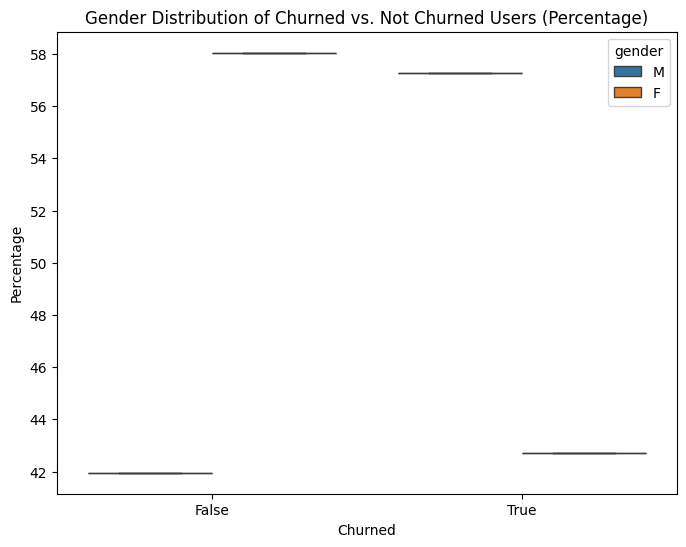

In [35]:

# Group by 'churned' and 'gender', and count the number of users in each group
grouped_data = final_df.groupBy("user_churned", "gender").count()


# Convert the grouped data to a Pandas DataFrame
grouped_data_pd = grouped_data.toPandas()

# Calculate the percentage of each gender within each group
total_counts = grouped_data_pd.groupby("user_churned")["count"].transform("sum")
grouped_data_pd["percentage"] = (grouped_data_pd["count"] / total_counts) * 100

# Create a box plot based on percentages
plt.figure(figsize=(8, 6))
sns.boxplot(data=grouped_data_pd, x="user_churned", y="percentage", hue="gender")
plt.title("Gender Distribution of Churned vs. Not Churned Users (Percentage)")
plt.xlabel("Churned")
plt.ylabel("Percentage")
plt.show()

A bar diagramm might be more suitable to show the gender related differences.

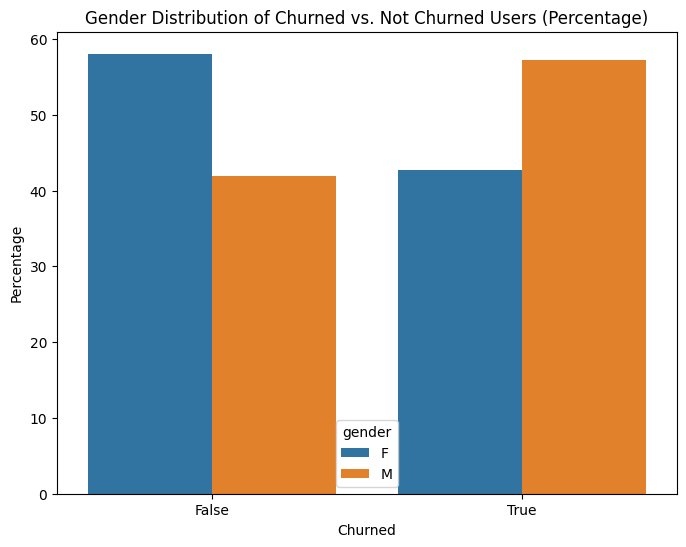

In [36]:
# Group by 'user_churned' and 'gender', and calculate the percentages
grouped_data = final_df.groupBy("user_churned", "gender").count()
total_counts = grouped_data.groupBy("user_churned").sum("count").withColumnRenamed("sum(count)", "total_count")
grouped_data = grouped_data.join(total_counts, on="user_churned")
grouped_data = grouped_data.withColumn("percentage", (grouped_data["count"] / grouped_data["total_count"]) * 100)

# Convert the grouped data to a Pandas DataFrame
grouped_data_pd = grouped_data.toPandas()

# Create a bar plot based on percentages
plt.figure(figsize=(8, 6))
sns.barplot(data=grouped_data_pd, x="user_churned", y="percentage", hue="gender")
plt.title("Gender Distribution of Churned vs. Not Churned Users (Percentage)")
plt.xlabel("Churned")
plt.ylabel("Percentage")
plt.show()


So it looks like there is at least some relation between the gender and churning.

<Figure size 1200x600 with 0 Axes>

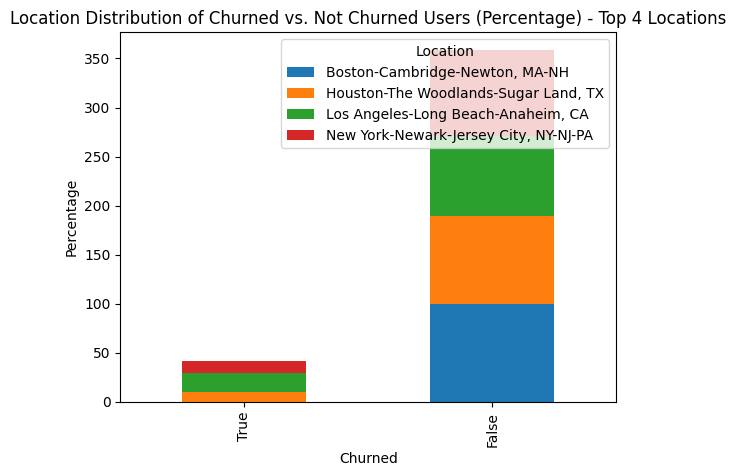

In [37]:
# Group by 'user_churned' and 'location', and count the number of users in each group
grouped_data = final_df.groupBy("user_churned", "location").count()

# Calculate the total count for each location
total_counts = grouped_data.groupBy("location").agg(Fsum("count").alias("total_count"))

# Get the top 4 most frequent locations
top_4_locations = total_counts.orderBy(desc("total_count")).limit(4)

# Filter the grouped data to include only the top 4 locations
filtered_grouped_data = grouped_data.join(top_4_locations, "location")

# Calculate the percentage of each location within each group
window_spec = Window.partitionBy(filtered_grouped_data['user_churned'])
filtered_grouped_data = filtered_grouped_data.withColumn("percentage", (filtered_grouped_data["count"] / filtered_grouped_data["total_count"]) * 100)

# Pivot the DataFrame to create separate columns for each location
pivot_data = filtered_grouped_data.groupBy("user_churned").pivot("location").agg(first("percentage"))

# Convert the pivot data to a Pandas DataFrame
pivot_data_pd = pivot_data.toPandas()

# Create a bar plot
plt.figure(figsize=(12, 6))
pivot_data_pd.plot(kind="bar", x="user_churned", stacked=True)
plt.title("Location Distribution of Churned vs. Not Churned Users (Percentage) - Top 4 Locations")
plt.xlabel("Churned")
plt.ylabel("Percentage")
plt.legend(title="Location", loc="upper right")
plt.show()



For locations there seems to be also a relation to churning.

## Statistics about page visits
We want to get an impression about how the visits to different pages are distributed between churned/not churned users.

In [38]:
# get unique page values
unique_pages = sorted(final_df.select("page").distinct().rdd.map(lambda row: row.page).collect())

# Show the list of unique page entries
print(unique_pages)

['About', 'Add Friend', 'Add to Playlist', 'Cancel', 'Cancellation Confirmation', 'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'NextSong', 'Roll Advert', 'Save Settings', 'Settings', 'Submit Downgrade', 'Submit Upgrade', 'Thumbs Down', 'Thumbs Up', 'Upgrade']


In [39]:
# get total number of churned/not churned users
# Drop duplicate rows based on 'userId' to ensure unique user counts
unique_user_df = final_df.dropDuplicates(["userId", "user_churned"])

# Group by 'user_churned' and count the number of unique users in each group
user_counts = unique_user_df.groupBy("user_churned").count()

# Show the result
user_counts.show()


+------------+-----+
|user_churned|count|
+------------+-----+
|        true|   52|
|       false|  173|
+------------+-----+



In [40]:
churned_users = user_counts.filter(user_counts['user_churned']==True).select('count').collect()[0][0]
not_churned_users = user_counts.filter(user_counts['user_churned']==False).select('count').collect()[0][0]
print(f'churned_users: {churned_users}, not_churned_users: {not_churned_users}')

churned_users: 52, not_churned_users: 173


In [41]:
# Group the data by 'user_churned' and 'page', and count the visits
grouped_data = final_df.groupBy("user_churned", "page").count()

avg_data = grouped_data.groupBy("user_churned", "page").avg("count")

# Convert the result to a Pandas DataFrame
avg_data_pd = avg_data.toPandas()

churned_data = avg_data_pd[avg_data_pd["user_churned"] == True]
not_churned_data = avg_data_pd[avg_data_pd["user_churned"] == False]

In [42]:
# Divide the "avg(count)" by the total count for each group
churned_data['relative_count'] = churned_data['avg(count)'] / churned_users
not_churned_data['relative_count'] =  not_churned_data['avg(count)'] / not_churned_users


/tmp/ipykernel_15019/3972187269.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churned_data['relative_count'] = churned_data['avg(count)'] / churned_users
/tmp/ipykernel_15019/3972187269.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_churned_data['relative_count'] =  not_churned_data['avg(count)'] / not_churned_users


In [43]:
# Sort the DataFrame by the 'page' column
churned_data = churned_data.sort_values(by='page')

# Reset the index of the sorted DataFrame
churned_data.reset_index(drop=True, inplace=True)

# Display the sorted DataFrame
print(churned_data)


    user_churned                       page  avg(count)  relative_count
0           True                      About        56.0        1.076923
1           True                 Add Friend       636.0       12.230769
2           True            Add to Playlist      1038.0       19.961538
3           True                     Cancel        52.0        1.000000
4           True  Cancellation Confirmation        52.0        1.000000
5           True                  Downgrade       337.0        6.480769
6           True                      Error        32.0        0.615385
7           True                       Help       239.0        4.596154
8           True                       Home      1672.0       32.153846
9           True                     Logout       553.0       10.634615
10          True                   NextSong     36394.0      699.884615
11          True                Roll Advert       967.0       18.596154
12          True              Save Settings        58.0        1

In [44]:
# only the churned users have visited the "cancel" and "cancellation confirmation" pages. Let us remove these from our df.
# Use boolean indexing to filter out rows with 'page' value 'Cancel' or 'Cancellation Confirmation'
churned_data = churned_data[~churned_data['page'].isin(['Cancel', 'Cancellation Confirmation'])]

# Reset the index of the filtered DataFrame
churned_data.reset_index(drop=True, inplace=True)

# Display the filtered DataFrame
print(churned_data)

    user_churned              page  avg(count)  relative_count
0           True             About        56.0        1.076923
1           True        Add Friend       636.0       12.230769
2           True   Add to Playlist      1038.0       19.961538
3           True         Downgrade       337.0        6.480769
4           True             Error        32.0        0.615385
5           True              Help       239.0        4.596154
6           True              Home      1672.0       32.153846
7           True            Logout       553.0       10.634615
8           True          NextSong     36394.0      699.884615
9           True       Roll Advert       967.0       18.596154
10          True     Save Settings        58.0        1.115385
11          True          Settings       270.0        5.192308
12          True  Submit Downgrade         9.0        0.173077
13          True    Submit Upgrade        32.0        0.615385
14          True       Thumbs Down       496.0        9

In [45]:

# Sort the DataFrame by the 'page' column
not_churned_data = not_churned_data.sort_values(by='page')

# Reset the index of the sorted DataFrame
not_churned_data.reset_index(drop=True, inplace=True)

# Display the sorted DataFrame
print(not_churned_data)

    user_churned              page  avg(count)  relative_count
0          False             About       439.0        2.537572
1          False        Add Friend      3641.0       21.046243
2          False   Add to Playlist      5488.0       31.722543
3          False         Downgrade      1718.0        9.930636
4          False             Error       220.0        1.271676
5          False              Help      1215.0        7.023121
6          False              Home      8410.0       48.612717
7          False            Logout      2673.0       15.450867
8          False          NextSong    191714.0     1108.173410
9          False       Roll Advert      2966.0       17.144509
10         False     Save Settings       252.0        1.456647
11         False          Settings      1244.0        7.190751
12         False  Submit Downgrade        54.0        0.312139
13         False    Submit Upgrade       127.0        0.734104
14         False       Thumbs Down      2050.0       11

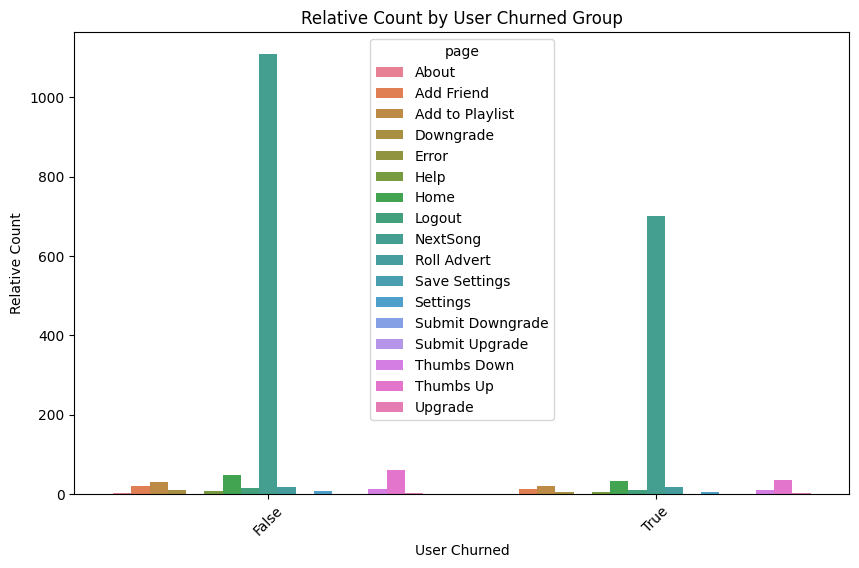

In [46]:
# Draw diagramm to show different page usage for churned/not churned users
combined_df = pd.concat([churned_data, not_churned_data])

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x="user_churned", y="relative_count", data=combined_df, hue="page")

# Set labels and title
plt.xlabel("User Churned")
plt.ylabel("Relative Count")
plt.title("Relative Count by User Churned Group")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()



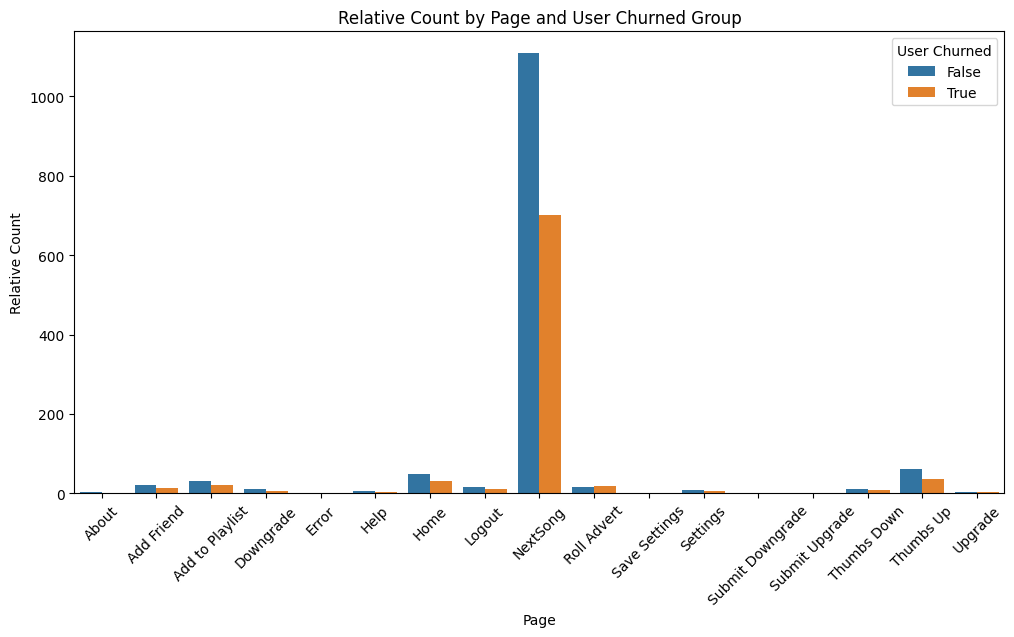

In [47]:
# Combine the two dataframes
combined_df = pd.concat([churned_data, not_churned_data])

# Create a grouped bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x="page", y="relative_count", data=combined_df, hue="user_churned")

# Set labels and title
plt.xlabel("Page")
plt.ylabel("Relative Count")
plt.title("Relative Count by Page and User Churned Group")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.legend(title="User Churned", loc="upper right")
plt.show()


from this we can assume that visits to "Add Friend", "Add to Playlist", "Nextsong" and "Thumbs Up" will have some impact on the prediction of user churns.

# Feature Engineering

We will use some of the attributes from the original dataset as well as newly constructed features.

Features from the dataset which might have an impact on quitting behavior might be:
* gender - maybe male users are more likely to quit (or maybe female)?
* location - maybe rural users are more likely to quit?

Additional features that will be derived from the dataset and might be useful:
* usage of playlists - are users with only few playlists/playlist entries more likely to quit?
* number of friends added - are users with more friends less likely to quit?
* songs per day - users which use the service more frequently might be less likely to quit 
* thumbs up - users which tend to give positive ratings might also be less likely to quit



## Categorical features from original dataset

In [48]:
result_df = final_df.select("userId", "gender", "location").distinct()
result_df.show(5)

+------+------+--------------------+
|userId|gender|            location|
+------+------+--------------------+
|100021|     M|Dallas-Fort Worth...|
|   139|     M|Los Angeles-Long ...|
|    41|     F|Manchester-Nashua...|
|    72|     F|  Port St. Lucie, FL|
|200016|     F|Baltimore-Columbi...|
+------+------+--------------------+
only showing top 5 rows



#### Function to extract categorical features

In [49]:
def get_df_for_categorical_features(df, cat_feature_names: list):
    '''Builds dataframe for categorical feature
    
        Args:
            df: a Pyspark dataframe
            cat_feature_names: list of attributes for which categorical features shall be constructed
            
        Returns:
            result_df: a new dataframe with userId as identifier and columns for only the categorical 
            features from cat_feature_names
    '''
    
    # Create a list of aggregation expressions
    agg_exprs = [first(f"{feature}").alias(f"{feature}") for feature in cat_feature_names]

    # Group by "userId" and apply the aggregation expressions
    result_df = df.groupBy("userId").agg(*agg_exprs)

    return result_df


In [50]:
cat_features = get_df_for_categorical_features(final_df, ['gender', 'location'])
cat_features.show(100)

+------+------+--------------------+
|userId|gender|            location|
+------+------+--------------------+
|    10|     M|          Laurel, MS|
|   100|     M|Dallas-Fort Worth...|
|100001|     F|Miami-Fort Lauder...|
|100002|     F|Santa Maria-Santa...|
|100003|     F|Miami-Fort Lauder...|
|100004|     F|        Syracuse, NY|
|100005|     M|          Monroe, LA|
|100006|     F|           Flint, MI|
|100007|     F|Little Rock-North...|
|100008|     F|Los Angeles-Long ...|
|100009|     M|San Francisco-Oak...|
|100010|     F|Bridgeport-Stamfo...|
|100011|     M|          Albany, OR|
|100012|     M|Chicago-Napervill...|
|100013|     F|Cleveland-Elyria, OH|
|100014|     M|New York-Newark-J...|
|100015|     F|North Wilkesboro, NC|
|100016|     M|    St. Louis, MO-IL|
|100017|     M|Birmingham-Hoover...|
|100018|     M|Dallas-Fort Worth...|
|100019|     M|Spokane-Spokane V...|
|100021|     M|Dallas-Fort Worth...|
|100022|     F|Houston-The Woodl...|
|100023|     M|Greenville-Anders...|
|

## Number of playlist entries and number of friends
For these we will only need to sum up the according events per userId

In [51]:
page_counts = final_df.groupBy("userId", "page").agg(count("*").alias("count"))

# Pivot the table to have 'page' values as columns
pivot_table = page_counts.groupBy("userId").pivot("page").sum("count")

# Fill any null values with 0
pivot_table = pivot_table.na.fill(0)

# Show the resulting DataFrame
# pivot_table.show()
wanted_cols = ['userId', 'Add to Playlist']

pivot_table.select(wanted_cols).show()

+------+---------------+
|userId|Add to Playlist|
+------+---------------+
|200002|              8|
|100010|              7|
|   125|              0|
|    51|             52|
|   124|            118|
|     7|              5|
|    54|             72|
|    15|             59|
|   155|             24|
|   132|             38|
|100014|              7|
|   154|              1|
|    11|             20|
|   101|             61|
|   138|             67|
|300017|            113|
|    29|             89|
|100021|              7|
|    69|             33|
|    42|            104|
+------+---------------+
only showing top 20 rows



In [52]:
def df_with_totals_per_user(df, events: list):
    '''Builds dataframe for features which contain totals per event
    
        Args:
            df: a Pyspark dataframe
            events: list of attributes for which new features shall be constructed
            
        Returns:
            pivot_table: a new dataframe with userId as identifier and columns for the new features 
    '''
    
    page_counts = df.groupBy("userId", "page").agg(count("*").alias("count"))

    # Pivot the table to have 'page' values as columns
    pivot_table = page_counts.groupBy("userId").pivot("page").sum("count")

    # Fill any null values with 0
    pivot_table = pivot_table.na.fill(0)

    # Strip all columns but the wanted
    events.append('userId')

    # Return the resulting DataFrame
    return pivot_table.select(events)


In [53]:
totals_df = df_with_totals_per_user(final_df, ['Add to Playlist', 'Add Friend', 'Nextsong', 'Thumbs Up'])
totals_df.show()

+---------------+----------+--------+---------+------+
|Add to Playlist|Add Friend|Nextsong|Thumbs Up|userId|
+---------------+----------+--------+---------+------+
|              8|         4|     387|       21|200002|
|              7|         4|     275|       17|100010|
|              0|         0|       8|        0|   125|
|             52|        28|    2111|      100|    51|
|            118|        74|    4079|      171|   124|
|              5|         1|     150|        7|     7|
|             72|        33|    2841|      163|    54|
|             59|        31|    1914|       81|    15|
|             24|        11|     820|       58|   155|
|             38|        41|    1928|       96|   132|
|              7|         6|     257|       17|100014|
|              1|         3|      84|       11|   154|
|             20|         6|     647|       40|    11|
|             61|        29|    1797|       86|   101|
|             67|        41|    2070|       95|   138|
|         

### Events per day
to redruce the dataset but to be still able to feed enough information to the trainings I decided to consolidate data per day. To do this I use the timestamp information and create a day entry from it. All events of same type (visits of same page) are consolidated per day that way

In [54]:
def df_with_event_sum_per_day_and_user(df, events: list):
    '''Builds dataframe for features for sum of event per day
       Features are per user and per event to sum up the event per day
    
        Args:
            df: a Pyspark dataframe
            events: list of attributes for which new features shall be constructed
            
        Returns:
            pivot_table: a new dataframe with userId as identifier and columns for the new features 
    '''
    
    # Add new columns for year, month, and day
    df = df.withColumn("ts_sec", df["ts"] / 1000)  # Convert milliseconds to seconds
    df = df.withColumn("year", year(df["ts_sec"].cast("timestamp")))
    df = df.withColumn("month", month(df["ts_sec"].cast("timestamp")))
    df = df.withColumn("day", dayofmonth(df["ts_sec"].cast("timestamp")))
    df = df.withColumn("year_month", concat_ws("_", df["year"], df["month"]))
    df = df.withColumn("year_month_day", concat_ws("_", df.year, df.month, df.day))

    # create new df which aggregates over the different pages (events)
    agg_df = df.groupby('userId','year_month_day', 'page').agg(count("*").alias('count'))

    # creae pivoted df with columns which contain the total number of events per day per user
    pivoted_df = agg_df.groupBy("userId", "year_month_day").pivot("page").sum("count")

    # Fill null values with 0 and rename columns
    pivoted_df = pivoted_df.na.fill(0)
    for event in events:
        pivoted_df = pivoted_df.withColumnRenamed(event, f"year_month_day_{event}")
    
    # Strip all columns but the wanted
    wanted_cols = [f"year_month_day_{event}" for event in events]
    wanted_cols.extend(['userId', 'year_month_day'])

    return pivoted_df.select(wanted_cols)

    

In first iteration I will only have 'NextSong' events handled that way.

In [55]:
next_song_event_per_day_df = df_with_event_sum_per_day_and_user(enhanced_df, ['NextSong'])
next_song_event_per_day_df.show()

+-----------------------+------+--------------+
|year_month_day_NextSong|userId|year_month_day|
+-----------------------+------+--------------+
|                      6|     8|    2018_11_23|
|                    103|    37|    2018_10_29|
|                     91|200023|     2018_10_1|
|                     14|    34|    2018_11_21|
|                    147|300005|    2018_10_11|
|                     32|200023|    2018_11_14|
|                     20|   141|     2018_10_8|
|                     10|   109|     2018_11_5|
|                     13|    56|    2018_11_28|
|                     25|    66|    2018_10_17|
|                     80|200006|    2018_11_22|
|                      8|200018|     2018_10_7|
|                     28|   118|    2018_11_21|
|                     44|    52|    2018_11_28|
|                    266|    97|    2018_11_26|
|                     33|    40|    2018_10_10|
|                     23|   142|    2018_10_20|
|                     18|300018|    2018

## Create now the feature dataset

We will here use the above defined functions to create a new dataframe containing all of the features we want to train.
To play around and add/remove features the variables below maybe used.
* cats_to_include: categorical features from the original dataset
* sums_to_include: totals per userId over events from page column of the original dataset
* per_day_to_include: features for "sum per day" over the events from page column of the original dataset



In [56]:
cats_to_include = ['gender', 'location']
sums_to_include = ['Add to Playlist', 'Add Friend', 'NextSong', 'Thumbs Up']
per_day_to_include = ['NextSong']

cat_features = get_df_for_categorical_features(enhanced_df, cats_to_include)
sum_features = df_with_totals_per_user(enhanced_df, sums_to_include)
per_day_features = df_with_event_sum_per_day_and_user(enhanced_df, per_day_to_include)

feature_df = cat_features.join(sum_features, on='userId', how='inner')\
    .join(per_day_features, on='userId', how='inner')

feature_df.show()

+------+------+--------------------+---------------+----------+--------+---------+-----------------------+--------------+
|userId|gender|            location|Add to Playlist|Add Friend|NextSong|Thumbs Up|year_month_day_NextSong|year_month_day|
+------+------+--------------------+---------------+----------+--------+---------+-----------------------+--------------+
|200002|     M|Chicago-Napervill...|              8|         4|     387|       21|                      8|    2018_11_16|
|200002|     M|Chicago-Napervill...|              8|         4|     387|       21|                     34|    2018_10_16|
|200002|     M|Chicago-Napervill...|              8|         4|     387|       21|                    117|    2018_10_18|
|200002|     M|Chicago-Napervill...|              8|         4|     387|       21|                      4|     2018_10_1|
|200002|     M|Chicago-Napervill...|              8|         4|     387|       21|                     20|     2018_10_2|
|200002|     M|Chicago-N

## Add the chunked_label
We now want to label all userId datasets for which there is a chunked value of 1.

In [57]:
def label_df(df):
    '''Builds the labels (churned/not churned) 
    
        Args:
            df: a Pyspark dataframe
            
        Returns:
            label_df: a new dataframe with userId and label churned
    '''
    # Aggregate the 'chunked' column to check if there's at least one '1' per user
    # Then use the 'when' function to create a new 'chunked_label' column
    label_df = df.groupBy('userId').agg(max(when(col('churned') >= 1, 1).otherwise(0)).alias('churned_label'))
    return label_df

In [58]:
label_df = label_df(enhanced_df)
# Filter the DataFrame to keep only rows where 'churned_label' is equal to 1
filtered_df = label_df.filter(label_df['churned_label'] == 1)

# Show the filtered DataFrame
filtered_df.show(5)

+------+-------------+
|userId|churned_label|
+------+-------------+
|   125|            1|
|    51|            1|
|    54|            1|
|100014|            1|
|   101|            1|
+------+-------------+
only showing top 5 rows



#### Join feature and label dataframes for the training

In [59]:
joined_df = feature_df.join(label_df, 'userId', 'inner')

In [60]:
joined_df.show(20)

+------+------+--------------------+---------------+----------+--------+---------+-----------------------+--------------+-------------+
|userId|gender|            location|Add to Playlist|Add Friend|NextSong|Thumbs Up|year_month_day_NextSong|year_month_day|churned_label|
+------+------+--------------------+---------------+----------+--------+---------+-----------------------+--------------+-------------+
|200002|     M|Chicago-Napervill...|              8|         4|     387|       21|                      8|    2018_11_16|            0|
|200002|     M|Chicago-Napervill...|              8|         4|     387|       21|                     34|    2018_10_16|            0|
|200002|     M|Chicago-Napervill...|              8|         4|     387|       21|                    117|    2018_10_18|            0|
|200002|     M|Chicago-Napervill...|              8|         4|     387|       21|                      4|     2018_10_1|            0|
|200002|     M|Chicago-Napervill...|            

In [61]:
joined_df.count()

3172

In [62]:
type(joined_df)

pyspark.sql.dataframe.DataFrame

Check for plausibility. There should be no user with churned_label both True and False!
How many churned/not churned do we have?

In [63]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import col


df = joined_df

# 1. Get userIds for which churned_label has only True values
true_users = df.groupBy("userId").agg({"churned_label": "min"}).filter(col("min(churned_label)") == True).select("userId")

# 2. Get userIds for which churned_label has only False values
false_users = df.groupBy("userId").agg({"churned_label": "max"}).filter(col("max(churned_label)") == False).select("userId")



In [64]:
print(f'Dataset contains a total of {joined_df.select("userId").distinct().count()} users from which {true_users.count()} have churned (and {false_users.count()} are still active).')

Dataset contains a total of 225 users from which 52 have churned (and 173 are still active).


### Make catgegorical features numerical

In [65]:
# Create StringIndexer for gender and location
gender_indexer = StringIndexer(inputCol="gender", outputCol="gender_index")
location_indexer = StringIndexer(inputCol="location", outputCol="location_index")

# Create OneHotEncoder for the indexed gender and location
gender_encoder = OneHotEncoder(inputCol="gender_index", outputCol="gender_encoded")
location_encoder = OneHotEncoder(inputCol="location_index", outputCol="location_encoded")

# Assemble the features into a single vector column
feature_cols = ["Add to Playlist", "Add Friend", "year_month_day_NextSong", "gender_encoded", "location_encoded"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Create a pipeline for the transformations
pipeline = Pipeline(stages=[gender_indexer, location_indexer, gender_encoder, location_encoder, assembler])

# Fit and transform the data using the pipeline
pipeline_model = pipeline.fit(joined_df)
joined_df = pipeline_model.transform(joined_df)



In [66]:
joined_df.show()

+------+------+--------------------+---------------+----------+--------+---------+-----------------------+--------------+-------------+------------+--------------+--------------+-----------------+--------------------+
|userId|gender|            location|Add to Playlist|Add Friend|NextSong|Thumbs Up|year_month_day_NextSong|year_month_day|churned_label|gender_index|location_index|gender_encoded| location_encoded|            features|
+------+------+--------------------+---------------+----------+--------+---------+-----------------------+--------------+-------------+------------+--------------+--------------+-----------------+--------------------+
|200002|     M|Chicago-Napervill...|              8|         4|     387|       21|                      8|    2018_11_16|            0|         1.0|           9.0|     (1,[],[])|  (113,[9],[1.0])|(117,[0,1,2,13],[...|
|200002|     M|Chicago-Napervill...|              8|         4|     387|       21|                     34|    2018_10_16|       

# Modeling
Split the full dataset into train and test sets. We will test out several  machine learning methods. The accuracies of the various models will be evaluated. The winning model will be choosen based on test accuracy and report results on the validation set. As our data is quite unbalanced we will use F1 score for this.

The F1 Score is a metric used to assess the balance between precision and recall in a classification model. It is the harmonic mean of precision and recall and is particularly useful when dealing with imbalanced datasets (which we have in our dataset regarding the high number of not churned user's data and low number of churned user's data). The F1 Score takes both false positives and false negatives into account, providing a single value that balances the trade-off between making precise positive predictions (precision) and capturing all positive instances (recall). It is calculated as:

F1 Score = 2 * (Precision * Recall) / (Precision + Recall)

A higher F1 Score indicates a model that achieves a good balance between precision and recall, making it a valuable metric for evaluating the performance of classification models, especially in situations where class distributions are unequal.

### Train/Test split

In [67]:
# Split the data into training and testing sets (e.g., 70% training, 30% testing)
train_ratio = 0.7
test_ratio = 1.0 - train_ratio
seed = 42

train_data, test_data = joined_df.randomSplit([train_ratio, test_ratio], seed=seed)


## Model for Logistic Regression

In [68]:
# Create a Logistic Regression model
lr = LogisticRegression(labelCol="churned_label")

# Set up a parameter grid for hyperparameter tuning
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.5, 1.0]) \
    .build()

#### Use cross-validation
Cross-validation helps to estimate how well our model will perform on unseen data. It provides a more robust evaluation of the model's performance, as it tests the model on multiple different subsets of the data.
I also use cross-validation here to  to tune hyperparameters in our models. By trying different hyperparameter settings on different cross-validation folds, we can find the settings that lead to the best overall performance.

In [69]:
# Create a cross-validator
evaluator = BinaryClassificationEvaluator(labelCol="churned_label")
cross_val = CrossValidator(estimator=lr, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5, seed=42)

# Fit the cross-validator to the training data
cv_model = cross_val.fit(train_data)


23/11/07 14:13:41 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


##### Evaluate
As data is quite unbalanced with relatively few churned entries we will use F1 for our model evaluation. F1-score as the evaluation metric is a good choice, as it takes both precision and recall into account and is suitable for imbalanced datasets as already stated above.

In [70]:

# Make predictions on the test data
predictions = cv_model.transform(test_data)

# Create a MulticlassClassificationEvaluator with metric "f1"
f1_evaluator = MulticlassClassificationEvaluator(labelCol="churned_label", metricName="f1")

# Calculate the F1-score on the test data
f1_score = f1_evaluator.evaluate(predictions)
print("F1-score: {:.2f}".format(f1_score))


F1-score: 0.92


## Model for Random Forest Classifier

In [71]:
# Create a RandomForest classifier
rf = RandomForestClassifier(labelCol="churned_label", featuresCol="features")

# Train the RandomForest model
rf_model = rf.fit(train_data)


## for maybe later usage of k-fold x-validation

# # Set up a parameter grid for hyperparameter tuning
# param_grid = ParamGridBuilder() \
#     .addGrid(rf.numTrees, [10, 20, 30, 50]) \
#     .addGrid(rf.maxDepth, [5, 10, 15]) \
#     .addGrid(rf.maxBins, [16, 32, 64]) \
#     .addGrid(rf.impurity, ["gini", "entropy"]) \
#     .addGrid(rf.featureSubsetStrategy, ["auto", "sqrt", "log2"]) \
#     .addGrid(rf.subsamplingRate, [0.6, 0.7, 0.8, 0.9, 1.0]) \
#     .build()

# # Train the RandomForest model
# cross_val = CrossValidator(estimator=rf, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5, seed=42)

# # Fit the cross-validator to the training data
# rf_model = cross_val.fit(train_data)

# Make predictions on the test data
predictions = rf_model.transform(test_data)

# Create a MulticlassClassificationEvaluator with metric "f1"
f1_evaluator = MulticlassClassificationEvaluator(labelCol="churned_label", metricName="f1")

# Calculate the F1-score on the test data
f1_score = f1_evaluator.evaluate(predictions)
print("F1-score: {:.2f}".format(f1_score))

F1-score: 0.77


## Model for Gradient Boosted Trees

In [72]:
# Create a GBT classifier
gbt = GBTClassifier(labelCol="churned_label", featuresCol="features")
evaluator = BinaryClassificationEvaluator(labelCol="churned_label")

# Train the GBT model
gbt_model = gbt.fit(train_data)

# Make predictions on the test data
predictions = gbt_model.transform(test_data)

# Create a MulticlassClassificationEvaluator with metric "f1"
f1_evaluator = MulticlassClassificationEvaluator(labelCol="churned_label", metricName="f1")

# Calculate the F1-score on the test data
f1_score = f1_evaluator.evaluate(predictions)
print("F1-score: {:.2f}".format(f1_score))

F1-score: 0.96


K-Fold X-Validation for Gradient Boosted Trees

In [ ]:
# # Create a GBT classifier
# gbt = GBTClassifier(labelCol="churned_label", featuresCol="features")
# evaluator = BinaryClassificationEvaluator(labelCol="churned_label")


# # Set up a parameter grid for hyperparameter tuning
# param_grid = ParamGridBuilder() \
#     .addGrid(gbt.maxIter, [10, 25, 50]) \
#     .addGrid(gbt.maxDepth, [5,  15]) \
#     .addGrid(gbt.maxBins, [16, 64]) \
#     .addGrid(gbt.stepSize, [0.01, 0.25, 0.5]) \
#     .build()

# # Train the RandomForest model
# cross_val = CrossValidator(estimator=gbt, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5, seed=42)

# # Fit the cross-validator to the training data
# gbt_model = cross_val.fit(train_data)

# # Make predictions on the test data
# predictions = gbt_model.transform(test_data)

# # Create a MulticlassClassificationEvaluator with metric "f1"
# f1_evaluator = MulticlassClassificationEvaluator(labelCol="churned_label", metricName="f1")

# # Calculate the F1-score on the test data
# f1_score = f1_evaluator.evaluate(predictions)
# print("F1-score: {:.2f}".format(f1_score))

In [ ]:
# # Save the best model
# best_model_path = "gbt_model.md"  # Replace with your desired path
# gbt_model.bestModel.save(best_model_path)

## Model for Support Vector Machine 

In [73]:
# Create a LinearSVC classifier
svm = LinearSVC(labelCol="churned_label", featuresCol="features")

# Train the SVM model
svm_model = svm.fit(train_data)

# for later k-fold x-validation

# # Set up a parameter grid for hyperparameter tuning
# param_grid = ParamGridBuilder() \
#     .addGrid(linear_svc.regParam, [0.01, 0.1, 1.0, 10.0]) \
#     .addGrid(linear_svc.maxIter, [10, 50, 100, 200]) \
#     .addGrid(linear_svc.tol, [1e-6, 1e-5, 1e-4]) \
#     .addGrid(linear_svc.standardization, [True, False]) \
#     .addGrid(linear_svc.fitIntercept, [True, False]) \
#     .build()

# # Train the RandomForest model
# cross_val = CrossValidator(estimator=svm, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5, seed=42)

# # Fit the cross-validator to the training data
# svm_model = cross_val.fit(train_data)

# Make predictions on the test data
predictions = svm_model.transform(test_data)

# Create a MulticlassClassificationEvaluator with metric "f1"
f1_evaluator = MulticlassClassificationEvaluator(labelCol="churned_label", metricName="f1")

# Calculate the F1-score on the test data
f1_score = f1_evaluator.evaluate(predictions)
print("F1-score: {:.2f}".format(f1_score))

F1-score: 0.92


SVM can be sensitive to feature scales, so it's generally a good practice to scale the features. Maybe we could improve model even further with doing this.

## Model for Naive Bayes

In [74]:
# Create a NaiveBayes classifier
nb = NaiveBayes(labelCol="churned_label", featuresCol="features")

# Train the Naive Bayes model
nb_model = nb.fit(train_data)


# for later k-fold x-validation

# # Set up a parameter grid for hyperparameter tuning
# param_grid = ParamGridBuilder() \
#     .addGrid(linear_svc.regParam, [0.01, 0.1, 1.0, 10.0]) \
#     .addGrid(linear_svc.maxIter, [10, 50, 100, 200]) \
#     .addGrid(linear_svc.tol, [1e-6, 1e-5, 1e-4]) \
#     .addGrid(linear_svc.standardization, [True, False]) \
#     .addGrid(linear_svc.fitIntercept, [True, False]) \
#     .build()

# # Train the  model
# cross_val = CrossValidator(estimator=nb, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5, seed=42)

# # Fit the cross-validator to the training data
# nb_model = cross_val.fit(train_data)

# Make predictions on the test data
predictions = nb_model.transform(test_data)

# Create a MulticlassClassificationEvaluator with metric "f1"
f1_evaluator = MulticlassClassificationEvaluator(labelCol="churned_label", metricName="f1")

# Calculate the F1-score on the test data
f1_score = f1_evaluator.evaluate(predictions)
print("F1-score: {:.2f}".format(f1_score))

F1-score: 0.71


# Results and Conclusions
|Model | F1 Score| Comment|
|-------|-----|-----|
|Logistic Regression| 0.92| Training has been performed here with 5-fold x-val over several params|
|Random Forest | 0.79| |
|Gradient Boosted Trees| 0.96| This model did perform right from the start with best F1 score. I would therefore do another try with 5-fold x-val over four different parameters.
|Support Vector Machine| 0.92|  SVM can be sensitive to feature scales. So it might be, we could even improve this result by normalizing our features (which I did not do)|
|Naive Bayes| 0.71| |